In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# !kill -9 -1 

In [12]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!free -g

              total        used        free      shared  buff/cache   available
Mem:             12           0           1           0          10          11
Swap:             0           0           0


In [13]:
!ls

datalab  drive


In [0]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from scipy.ndimage.interpolation import shift
from keras.models import load_model
import keras
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
nb_samples = 25000
nb_words  = 1000

In [0]:
def return_text(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return lines

In [0]:
# test_from = return_text('/data/test.from')
train_from = return_text('drive/projects/chatbot-reddit/data/train.from')
# test_to = return_text('drive/projects/chatbot-reddit/data/test.to')
train_to = return_text('drive/projects/chatbot-reddit/data/train.to')

In [0]:
def clean_sentences(sentences):
    n_sentences=[]
    temp = ''
    for sentence in sentences:
        if '\n' in sentence:
            loc = sentence.find('\n')
        temp = "sos "+sentence[:loc] + " eos"
        n_sentences.append(temp)
        temp=''
    return n_sentences

In [0]:
cleaned_trainfrom = clean_sentences(train_from)
cleaned_trainto = clean_sentences(train_to)

In [20]:
cleaned_trainfrom[0]

'sos As always Dilbert is so true. newlinechar  newlinechar Funny thing about Strategy is that you can have the right Strategy and still find yourself worse off. eos'

In [0]:
tokenizer = Tokenizer(num_words = nb_words,lower=True)
tokenizer.fit_on_texts(cleaned_trainfrom + cleaned_trainto)

In [22]:
len(tokenizer.word_index)

48311

In [0]:
train_from_sequences = tokenizer.texts_to_sequences(cleaned_trainfrom)
train_to_sequences = tokenizer.texts_to_sequences(cleaned_trainto)

In [0]:
# test_to_sequences = tokenizer.texts_to_sequences(test_to)
# test_from_sequences = tokenizer.texts_to_sequences(test_from)

In [0]:
max_seq_train_from = max([len(seq) for seq in train_from_sequences])
max_seq_train_to = max([len(seq) for seq in train_to_sequences])

In [26]:
max_seq_train_from,max_seq_train_to

(87, 77)

In [0]:
data_trainfrom = pad_sequences(train_from_sequences, maxlen=max_seq_train_from)
data_trainto = pad_sequences(train_to_sequences, maxlen=max_seq_train_to)

In [0]:
# data_testfrom = pad_sequences(train_from_sequences, maxlen=max_seq_train_from)
# data_testto = pad_sequences(train_to_sequences, maxlen=max_seq_train_to)

In [29]:
data_trainfrom[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  31, 179,
        13,  36, 214,   4,   4, 285, 132,  48,  13,  12,  10,  49,  20,
         3,  92,   9, 101, 192, 430, 515, 129,   2], dtype=int32)

In [0]:
# data_trainfrom = data_trainfrom[:nb_samples]
# data_trainto = data_trainto [:nb_samples]

In [31]:
data_trainfrom.shape,data_trainto.shape

((28778, 87), (28778, 77))

In [0]:
# def shift2(arr,num):
#     arr=np.roll(arr,num)
#     if num<0:
#          np.put(arr,range(len(arr)+num,len(arr)),0)
#     elif num > 0:
#          np.put(arr,range(num),0)
#     return arr

In [0]:
# target_data = shift2(data_trainto, -1)
# target_data = target_data[:nb_samples]

In [0]:
new_tokens = {}
for token, val in  tokenizer.word_index.items():
  if(val<nb_words):
    if re.match('^[a-zA-Z0-9]',token ):
        new_tokens[token] = val
  else:
    break
num_tokens = len(new_tokens)

In [0]:
index2word = {}
for word,i in new_tokens.items():
    index2word[i] = word

In [36]:
index2word[998]

'million'

In [37]:
new_tokens['eos']

2

In [0]:
# X = np.zeros((nb_samples,max_seq_train_from, num_tokens+1), dtype='float32')
# X_context = np.zeros((nb_samples,max_seq_train_to, num_tokens+1), dtype='float32')
nb_samples = data_trainfrom.shape[0]
Y = np.zeros((nb_samples,max_seq_train_to, nb_words), dtype='float32')


for i, target_text in enumerate(cleaned_trainto):
  for t, word in enumerate(target_text.split(' ')):
    if word in new_tokens and i<nb_samples and new_tokens[word]< nb_words:
      if t > 0:          
        # decoder_target_data will be ahead by one timestep
        # and will not include the start character.
        Y[i, t - 1, new_tokens[word]] = 1.

In [39]:
Y.shape

(28778, 77, 1000)

In [0]:
path = 'drive/projects/chatbot-reddit'

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense 
from keras.models import Model
from keras import optimizers

In [0]:
latent_dim = 256
batch_size = 128
epochs = 50

In [0]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
x = Embedding(nb_words, latent_dim)(encoder_inputs)
encoder, state_h, state_c = LSTM(latent_dim,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
y = Embedding(nb_words, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True,return_state=True)
d_out, _, _ = decoder_lstm(y, initial_state=encoder_states)
decoder_dense = Dense(nb_words, activation='softmax')
decoder_outputs = decoder_dense(d_out)

In [0]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [0]:
callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.1,
            patience=10,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(path,'models/chatbotC.h5'),
            monitor='loss',
            save_best_only=True,
        ),
]

In [74]:
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.load_weights(os.path.join(path,'models/chatbotC.h5'))
history = model.fit([data_trainfrom, data_trainto], Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,
          callbacks = callbacks_list)

Train on 25900 samples, validate on 2878 samples
Epoch 1/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6203 - val_loss: 0.6230
Epoch 2/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6193 - val_loss: 0.6239


/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 3/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6183 - val_loss: 0.6237
Epoch 4/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6172 - val_loss: 0.6236
Epoch 5/50
19840/25900 [=====================>........] - ETA: 19s - loss: 0.6162

25900/25900 [==============================] - 87s 3ms/step - loss: 0.6161 - val_loss: 0.6248
Epoch 6/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6147 - val_loss: 0.6253
Epoch 7/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6132 - val_loss: 0.6260
Epoch 8/50
 1024/25900 [>.............................] - ETA: 1:24 - loss: 0.5862

25900/25900 [==============================] - 87s 3ms/step - loss: 0.6115 - val_loss: 0.6264
Epoch 9/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6096 - val_loss: 0.6272
Epoch 10/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.6084

25900/25900 [==============================] - 87s 3ms/step - loss: 0.6074 - val_loss: 0.6285
Epoch 11/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6050 - val_loss: 0.6296
Epoch 12/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.6026 - val_loss: 0.6306
Epoch 13/50
 1408/25900 [>.............................] - ETA: 1:21 - loss: 0.5748

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5998 - val_loss: 0.6320
Epoch 14/50
25900/25900 [==============================] - 86s 3ms/step - loss: 0.5968 - val_loss: 0.6337
Epoch 15/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.5940

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5936 - val_loss: 0.6359
Epoch 16/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5903 - val_loss: 0.6380
Epoch 17/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5868 - val_loss: 0.6403
Epoch 18/50
 1408/25900 [>.............................] - ETA: 1:22 - loss: 0.5775

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5832 - val_loss: 0.6428
Epoch 19/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5795 - val_loss: 0.6433
Epoch 20/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.5752

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5756 - val_loss: 0.6458
Epoch 21/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5716 - val_loss: 0.6484
Epoch 22/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5678 - val_loss: 0.6518
Epoch 23/50
 1408/25900 [>.............................] - ETA: 1:22 - loss: 0.5730

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5638 - val_loss: 0.6540
Epoch 24/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5598 - val_loss: 0.6574
Epoch 25/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.5542

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5558 - val_loss: 0.6597
Epoch 26/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5518 - val_loss: 0.6630
Epoch 27/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5478 - val_loss: 0.6659
Epoch 28/50
 1408/25900 [>.............................] - ETA: 1:22 - loss: 0.5376

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5436 - val_loss: 0.6694
Epoch 29/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5398 - val_loss: 0.6705
Epoch 30/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.5327

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5359 - val_loss: 0.6762
Epoch 31/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5319 - val_loss: 0.6782
Epoch 32/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5281 - val_loss: 0.6842
Epoch 33/50
 1408/25900 [>.............................] - ETA: 1:22 - loss: 0.5240

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5243 - val_loss: 0.6857
Epoch 34/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5205 - val_loss: 0.6886
Epoch 35/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.5153

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5169 - val_loss: 0.6916
Epoch 36/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5132 - val_loss: 0.6944
Epoch 37/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5096 - val_loss: 0.6988
Epoch 38/50
 1408/25900 [>.............................] - ETA: 1:21 - loss: 0.5114

25900/25900 [==============================] - 87s 3ms/step - loss: 0.5061 - val_loss: 0.7024
Epoch 39/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.5026 - val_loss: 0.7078
Epoch 40/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.4989

25900/25900 [==============================] - 87s 3ms/step - loss: 0.4994 - val_loss: 0.7103
Epoch 41/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.4960 - val_loss: 0.7156
Epoch 42/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.4925 - val_loss: 0.7168
Epoch 43/50
 1408/25900 [>.............................] - ETA: 1:22 - loss: 0.4714

25900/25900 [==============================] - 87s 3ms/step - loss: 0.4893 - val_loss: 0.7222
Epoch 44/50
25900/25900 [==============================] - 87s 3ms/step - loss: 0.4861 - val_loss: 0.7224
Epoch 45/50
22784/25900 [=========================>....] - ETA: 10s - loss: 0.4808

25900/25900 [==============================] - 87s 3ms/step - loss: 0.4831 - val_loss: 0.7252
Epoch 46/50
25900/25900 [==============================] - 85s 3ms/step - loss: 0.4799 - val_loss: 0.7316
Epoch 47/50
25900/25900 [==============================] - 86s 3ms/step - loss: 0.4770 - val_loss: 0.7333
Epoch 48/50
 1408/25900 [>.............................] - ETA: 1:20 - loss: 0.4808

25900/25900 [==============================] - 85s 3ms/step - loss: 0.4741 - val_loss: 0.7374
Epoch 49/50
25900/25900 [==============================] - 85s 3ms/step - loss: 0.4709 - val_loss: 0.7427
Epoch 50/50
22784/25900 [=========================>....] - ETA: 9s - loss: 0.4678 

25900/25900 [==============================] - 85s 3ms/step - loss: 0.4682 - val_loss: 0.7452


In [0]:
def sample(preds, temperature= 0.2):
    preds = np.reshape(preds,preds.shape[-1])
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds, 1)
    return np.argmax(probas)

In [76]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
print(encoder_model.summary())
                    
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_inputs = Input(shape=(None,))
y = Embedding(nb_words, latent_dim)(decoder_inputs)
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(y, initial_state=decoder_states_inputs)
decoder_states  = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model   = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
print(decoder_model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         256000    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 781,312
Trainable params: 781,312
Non-trainable params: 0
_________________________________________________________________
None
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________

In [77]:
index2word[1]

'sos'

In [78]:
data_trainto[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   1, 113,   7,   3, 304,   8,  59,  96,  10,  20,
        31,   5,   7,  34, 758,   7,   5, 413, 602,  14, 584,   7,  88,
         5, 413,   7,   3,   8,   5,   9,   7,  31,   5, 301,   2],
      dtype=int32)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,max_seq_train_to))
    # Populate the first character of target sequence with the start character.
    target_seq[0,-1] = new_tokens['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([input_seq] + states_value)
      # Sample a token
      sampled_token_index = sample(output_tokens[0, -1, :] ,0.9)
      sampled_char = index2word[sampled_token_index]
      decoded_sentence += sampled_char +" "

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
         len(decoded_sentence) > max_seq_train_to):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,max_seq_train_to))
      target_seq[0, -1] = sampled_token_index

      # Update states
      states_value = [h, c]

    return decoded_sentence

In [0]:
def make_inference(sentence):
    input_text_seq = tokenizer.texts_to_sequences(sentence)
    input_data_padded = pad_sequences(input_text_seq, maxlen=max_seq_train_from)
    decoded_sentence = decode_sequence(input_data_padded)
    print('Question:', sentence)
    print('Reply:', decoded_sentence)

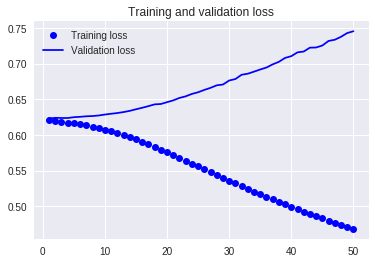

In [89]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()